# 0. Imports

In [29]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from queue import PriorityQueue
from copy import deepcopy
from time import time
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 0.1 Accessibility

In [30]:
colorVisionDeficiencyMode = False

# 1. Helper Classes

## 1.1 Perlin Noise

In [31]:
# Perline noise code courtesy of tgroid on SO
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)
    return lerp(x1,x2,v)

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

if __name__ == 'main':
    lin = np.linspace(0,5,100,endpoint=False)
    x,y = np.meshgrid(lin,lin)

    plt.imshow(perlin(x,y,seed=5),origin='upper')
    plt.show()

## 1.2 Point

In [32]:
class Point():

	def __init__(self, posx, posy):
		self.x = posx
		self.y = posy
		self.comparator = math.inf

	def __lt__(self, other):
		return self.comparator < other.comparator

	def __gt__(self, other):
		return self.comparator > other.comparator

	def __eq__(self, other):
		return self.x == other.x and self.y == other.y

## 1.3 Map

In [33]:
def scale(X):
	X = ((X+1)/2 * 255).astype(int)
	return X

class Map():

	def __init__(self, length, width, cost_function='exp',seed=None,
	             filename=None, start=None, goal=None):

		self.seed = seed
		if self.seed == None:
			# Randomly assign seed from 0 to 10k if not provided
			self.seed = randint(0,10000)
		self.length = length
		self.width = width
		self.generateTerrain(filename)
		self.explored = []
		self.explored_lookup = {}
		for i in range(self.width):
			for j in range(self.length):
				self.explored_lookup[str(i)+','+str(j)] = False
		if start == None:
			self.start = Point(int(self.width*0.5),int(self.length*0.5))
		else:
			self.start = Point(start[0], start[1])
		if goal == None:
			self.goal = Point(int((self.width-1)*0.9),int((self.length-1)*0.9))
		else:
			self.goal = Point(goal[0], goal[1])
		if cost_function == 'exp':
			self.cost_function = lambda h0, h1: math.pow(math.e,h1-h0)
		elif cost_function == 'div':
			self.cost_function = lambda h0, h1: h0/(h1+1)
		self.cmap = mpl.colors.ListedColormap(['white', 'red'])
		if colorVisionDeficiencyMode:
			self.cmap = mpl.colors.ListedColormap(['white', 'magenta'])

	'''generateTerrain: modifes self.map to either be the specified file, or
	randomly generated from perlin noise.
	input:
	filename - str, string of the npy file to generate the map
	seed - int, integer for reproducibility of a particular map
	octaves - int parameter for perlin noise
	output:
	None, self.map modified'''
	def generateTerrain(self, filename=None):
		if filename is None:
			linx = np.linspace(0,5,self.width,endpoint=False)
			liny = np.linspace(0,5,self.length,endpoint=False)
			x,y = np.meshgrid(linx,liny)
			self.map = scale(perlin(x, y, seed=self.seed))

		else:
			self.map = np.load(filename)
			self.width = self.map.shape[0]
			self.length = self.map.shape[1]

	def interpolate(self, a0, a1, w):
		if (0.0 > w):
			return a0
		if (1.0 < w):
			return a1
		return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w ** 3) + a0

	def calculatePathCost(self, path):
		prev = path[0]
		if self.start != prev:
			print('Path does not start at start. Path starts at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		cost = 0
		for item in path[1:]:
			if self.isAdjacent(prev, item):
				cost += self.getCost(prev, item)
				prev = item
			else:
				print('Path does not connect at points: ', str(prev.x), ',', str(prev.y),
					' and ', str(item.x), ',', str(item.y))
				return math.inf
		if prev != self.goal:
			print('Path does not end at goal. Path ends at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		return cost

	def validTile(self, x, y):
		return x >= 0 and y >= 0 and x < self.width and y < self.length

	'''def validTile(self, p1):
		return self.validTile(p1.x, p1.y)'''

	def getTile(self, x, y):
		return self.map[x][y]

	'''def getTile(self, p1):
		return self.getTile(p1.x, p1.y)'''

	def getCost(self, p1, p2):
		h0 = self.getTile(p1.x, p1.y)
		h1 = self.getTile(p2.x, p2.y)
		return self.cost_function(h0, h1)

	def isAdjacent(self, p1, p2):
		return (abs(p1.x - p2.x) == 1 or abs(p1.y - p2.y)) == 1 and (abs(p1.x - p2.x) < 2 and abs(p1.y - p2.y) < 2)

	def getNeighbors(self, p1):
		neighbors = []
		for i in [-1, 0, 1]:
			for j in [-1, 0, 1]:
				if i == 0 and j == 0:
					continue
				possible_point = Point(p1.x + i, p1.y + j)
				if self.validTile(possible_point.x, possible_point.y):
					neighbors.append(possible_point)
					if not self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)]:
						self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)] = True
						self.explored.append(possible_point)
		return neighbors

	def getStartPoint(self):
		return self.start

	def getEndPoint(self):
		return self.goal

	def getHeight(self):
		return np.amax(self.map)

	'''Creates a 2D image of the path taken and nodes explroed, prints
	pathcost and number of nodes explored'''
	def createImage(self, path):
		img = self.map
		path_img = np.zeros_like(self.map)
		explored_img = np.zeros_like(self.map)
		for item in self.explored:
			explored_img[item.x, item.y] = 1
		path_img_x = [item.x for item in path]
		path_img_y = [item.y for item in path]
		print('Path cost:', self.calculatePathCost(path))
		print('Nodes explored: ', len(self.explored) + len(path))
		plt.imshow(img, cmap='gray')
		plt.imshow(explored_img, cmap=self.cmap, alpha=0.3)
		plt.plot(path_img_y, path_img_x, color='blue', linewidth=1)
		plt.show()

	'''Set the start and goal point on the 2D map, each point is a pair of integers'''
	def setStartGoal(self, start, goal):
		self.start = Point(np.clip(start[0], 0, self.length-1), np.clip(start[1], 0, self.width-1))
		self.goal = Point(np.clip(goal[0], 0, self.length-1), np.clip(goal[1], 0, self.width-1))

# 2. AI Modules

You'll write your code here!

## 2.1 AI Module & Dijkstras

In [34]:
'''AIModule Interface
createPath(map map_) -> list<points>: Adds points to a path'''
class AIModule:

	def createPath(self, map_):
		pass

'''
A sample AI that takes a very suboptimal path.
This is a sample AI that moves as far horizontally as necessary to reach
the target, then as far vertically as necessary to reach the target.
It is intended primarily as a demonstration of the various pieces of the
program.
'''
class StupidAI(AIModule):

	def createPath(self, map_):
		path = []
		explored = []
		# Get starting point
		path.append(map_.start)
		current_point = deepcopy(map_.start)

		# Keep moving horizontally until we match the target
		while(current_point.x != map_.goal.x):
			# If we are left of goal, move right
			if current_point.x < map_.goal.x:
				current_point.x += 1
			# If we are right of goal, move left
			else:
				current_point.x -= 1
			path.append(deepcopy(current_point))

		# Keep moving vertically until we match the target
		while(current_point.y != map_.goal.y):
			# If we are left of goal, move right
			if current_point.y < map_.goal.y:
				current_point.y += 1
			# If we are right of goal, move left
			else:
				current_point.y -= 1
			path.append(deepcopy(current_point))

		# We're done!
		return path

class Dijkstras(AIModule):

	def createPath(self, map_):
		q = PriorityQueue()
		''' Maintain three dictionaries to keep track of cost ("x,y" -> cost per
		node), previous (node -> parent). This keeps track of paths, and explored
		which helps us run faster by ignoring nodes already visited'''
		cost = {}
		prev = {}
		explored = {}
		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):
				cost[(i,j)] = math.inf
				prev[(i,j)] = None
				explored[(i,j)] = False
		current_point = deepcopy(map_.start)
		current_point.comparator = 0
		cost[(current_point.x, current_point.y)] = 0
		# Add start node to the queue
		q.put(current_point)
		# Search loop
		while q.qsize() > 0:
			# Get new point from PQ
			v = q.get()
			if explored[(v.x,v.y)]:
				continue
			explored[(v.x,v.y)] = True
			# Check if popping off goal
			if v == map_.getEndPoint():
				break
			# Evaluate neighbors
			neighbors = map_.getNeighbors(v)
			for neighbor in neighbors:
				alt = map_.getCost(v, neighbor) + cost[(v.x,v.y)]
				if alt < cost[(neighbor.x,neighbor.y)]:
					cost[(neighbor.x,neighbor.y)] = alt
					neighbor.comparator = alt
					prev[(neighbor.x,neighbor.y)] = v
				q.put(neighbor)
		# Find and return path
		path = []
		while v != map_.getStartPoint():
			path.append(v)
			v = prev[(v.x,v.y)]
		path.append(map_.getStartPoint())
		path.reverse()
		return path

## 2.2 AIExp and AIMSH
Here, specifically

In [183]:
class AStarExp(AIModule):

	def createPath(self, map_):

			def heuristic(self, map_, neighbor):

				if neighbor != map_.getEndPoint():
					deltaX = abs(neighbor.x - map_.getEndPoint().x)
					deltaY = abs(neighbor.y - map_.getEndPoint().y)
					height = map_.getTile(map_.getEndPoint().x, map_.getEndPoint().y ) - map_.getTile(neighbor.x, neighbor.y)
					chebyshev = max(deltaX, deltaY, height)
					penalty = math.e

					if chebyshev != height:
						penalty = penalty ** (height/chebyshev)
					return chebyshev * penalty
				else:
					return 0

			q = PriorityQueue()
			cost = {}
			prev = {}
			explored = {}

			for i in range(map_.width):
				for j in range(map_.length):
					cost[(i,j)] = math.inf
					prev[(i,j)] = None
					explored[(i,j)] = False
			current_point = deepcopy(map_.start)
			current_point.comparator = 0
			cost[(current_point.x, current_point.y)] = 0

			q.put(current_point)

			while q.qsize() > 0:
				v = q.get()
				if explored[(v.x, v.y)]:
					continue
				explored[(v.x, v.y)] = True

				if v == map_.getEndPoint():
					break

				neighbors = map_.getNeighbors(v)
				for neighbor in neighbors:
					alt = map_.getCost(v, neighbor) + cost[(v.x, v.y)]
					if alt < cost[(neighbor.x, neighbor.y)]:
						cost[(neighbor.x, neighbor.y)] = alt
						prev[(neighbor.x, neighbor.y)] = v
						neighbor.comparator = alt + heuristic(self, map_, neighbor)
						q.put(neighbor)


			path = []
			while v!= map_.getStartPoint():
				path.append(v)
				v = prev[(v.x, v.y)]
			path.append(map_.getStartPoint())
			path.reverse()
			return path

class AStarDiv(AIModule):

	def createPath(self, map_):

			def heuristic(self, map_, neighbor):

				if neighbor != map_.getEndPoint():
					deltaX = abs(neighbor.x - map_.getEndPoint().x)
					deltaY = abs(neighbor.y - map_.getEndPoint().y)
					height = map_.getTile(map_.getEndPoint().x, map_.getEndPoint().y ) - map_.getTile(neighbor.x, neighbor.y)
					chebyshev = max(deltaX, deltaY, height)
					penalty = map_.getTile(neighbor.x, neighbor.y)/(map_.getTile(map_.getEndPoint().x, map_.getEndPoint().y)+1)

					if chebyshev != height:
						penalty = penalty ** (height/chebyshev)
					return chebyshev * penalty
				else:
					return 0

			q = PriorityQueue()
			cost = {}
			prev = {}
			explored = {}

			for i in range(map_.width):
				for j in range(map_.length):
					cost[(i,j)] = math.inf
					prev[(i,j)] = None
					explored[(i,j)] = False
			current_point = deepcopy(map_.start)
			current_point.comparator = 0
			cost[(current_point.x, current_point.y)] = 0

			q.put(current_point)

			while q.qsize() > 0:
				v = q.get()
				if explored[(v.x, v.y)]:
					continue
				explored[(v.x, v.y)] = True

				if v == map_.getEndPoint():
					break

				neighbors = map_.getNeighbors(v)
				for neighbor in neighbors:
					alt = map_.getCost(v, neighbor) + cost[(v.x, v.y)]
					if alt < cost[(neighbor.x, neighbor.y)]:
						cost[(neighbor.x, neighbor.y)] = alt
						prev[(neighbor.x, neighbor.y)] = v
						neighbor.comparator = alt + heuristic(self, map_, neighbor)
						q.put(neighbor)


			path = []
			while v!= map_.getStartPoint():
				path.append(v)
				v = prev[(v.x, v.y)]
			path.append(map_.getStartPoint())
			path.reverse()
			return path


class AStarMSH(AIModule):

	def createPath(self, map_):

			def heuristic(self, map_, neighbor):

				if neighbor != map_.getEndPoint():
					deltaX = abs(neighbor.x - map_.getEndPoint().x)
					deltaY = abs(neighbor.y - map_.getEndPoint().y)
					height = map_.getTile(map_.getEndPoint().x, map_.getEndPoint().y ) - map_.getTile(neighbor.x, neighbor.y)
					chebyshev = max(deltaX, deltaY, height)
					penalty = math.e

					if chebyshev != height:
						penalty = penalty ** (height/chebyshev)
					return chebyshev * penalty
				else:
					return 0

			q = PriorityQueue()
			cost = {}
			prev = {}
			explored = {}

			for i in range(map_.width):
				for j in range(map_.length):
					cost[(i,j)] = math.inf
					prev[(i,j)] = None
					explored[(i,j)] = False
			current_point = deepcopy(map_.start)
			current_point.comparator = 0
			cost[(current_point.x, current_point.y)] = 0

			q.put(current_point)

			while q.qsize() > 0:
				v = q.get()
				if explored[(v.x, v.y)]:
					continue
				explored[(v.x, v.y)] = True

				if v == map_.getEndPoint():
					break

				neighbors = map_.getNeighbors(v)
				for neighbor in neighbors:
					alt = map_.getCost(v, neighbor) + cost[(v.x, v.y)]
					if alt < cost[(neighbor.x, neighbor.y)]:
						cost[(neighbor.x, neighbor.y)] = alt
						prev[(neighbor.x, neighbor.y)] = v
						g_weight = 0.4
						h_weight = 0.4
						neighbor.comparator = g_weight* alt + h_weight * heuristic(self, map_, neighbor)
						q.put(neighbor)


			path = []
			while v!= map_.getStartPoint():
				path.append(v)
				v = prev[(v.x, v.y)]
			path.append(map_.getStartPoint())
			path.reverse()
			return path


# 3. Run

## 3.1 Setup

w(int): Width of map

l(int): Length of map

start(array-like<int>): Start position

goal(array-like<int>): Goal position

seed(int): Seed for random generation

AI(AIModule): AI agent to use. Use any of the following: AStarExp, AStarDiv, AStarMSH, Djikstras

filename(string): Filepath for .npy file to be used for map

In [138]:
w = 500
l = 500
start = None
goal = None
seed = 0
cost_function = 'exp'
#cost_function = 'div'
AI = AStarMSH()
filename = None

## 3.2 Run

Time (s):  2.8600380420684814
Path cost: 623.147761261973
Nodes explored:  15908


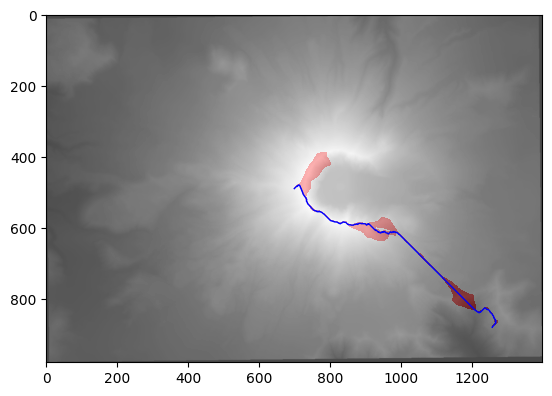

In [147]:
m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

# 4. Tests

## 4.1 AStarExp

In [175]:
cost_function = 'exp'

Time (s):  2.624593496322632
Path cost: 241.55253710831192
Nodes explored:  18667


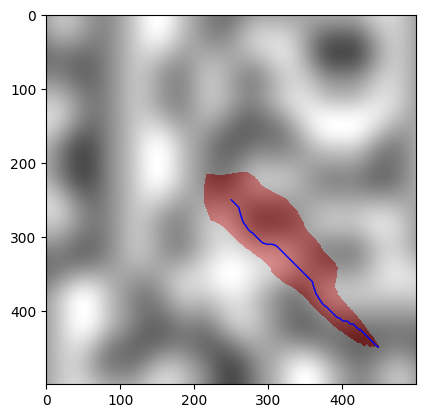

In [173]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarExp() after implemented
AI = AStarExp()
filename = None

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.8804214000701904
Path cost: 238.5060683830129
Nodes explored:  11717


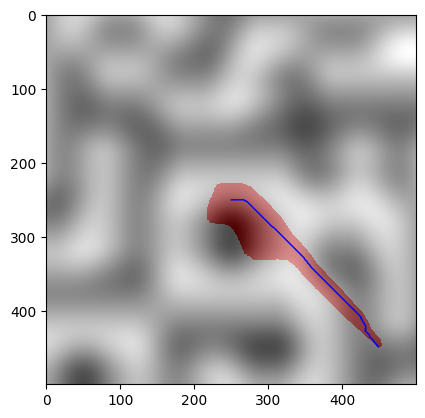

In [174]:
seed = 1

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  2.0286526679992676
Path cost: 236.667690049357
Nodes explored:  14982


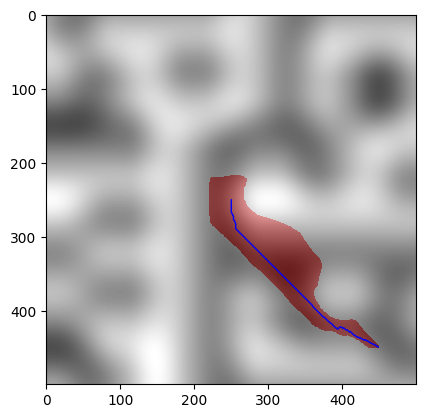

In [170]:
seed = 2

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  1.8319997787475586
Path cost: 422.01798243905006
Nodes explored:  23462


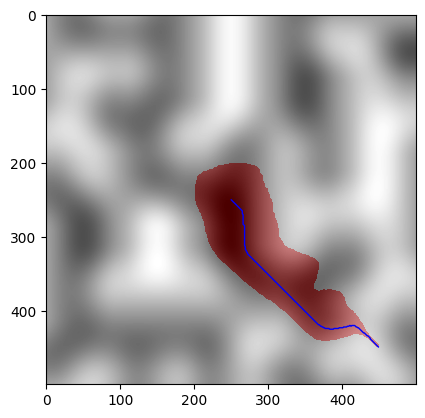

In [162]:
seed = 3

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  1.2490344047546387
Path cost: 254.34464507852198
Nodes explored:  9843


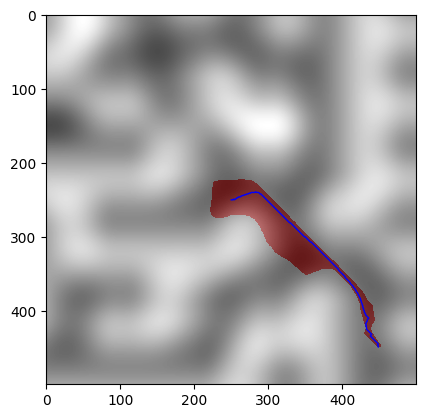

In [163]:
seed = 4

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.1 AStarDiv

In [143]:
cost_function = 'div'

Time (s):  1.9395065307617188
Path cost: 197.67690128917357
Nodes explored:  15892


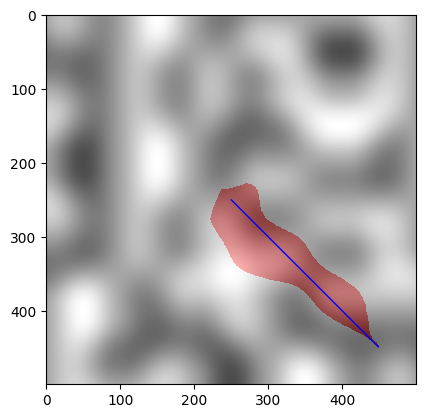

In [144]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarDiv() after implemented
AI = AStarDiv()
filename = None

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.5499989986419678
Path cost: 197.71721595331226
Nodes explored:  5841


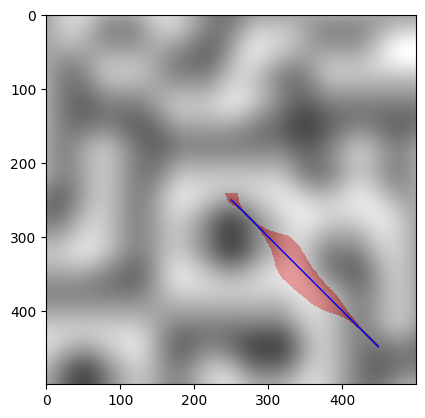

In [63]:
seed = 1

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.6835508346557617
Path cost: 197.58110211547168
Nodes explored:  4994


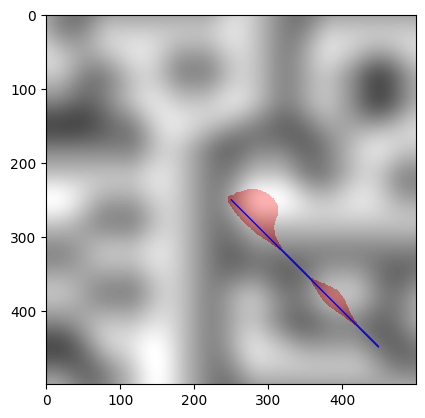

In [64]:
seed = 2

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.7496492862701416
Path cost: 196.29556836229682
Nodes explored:  9661


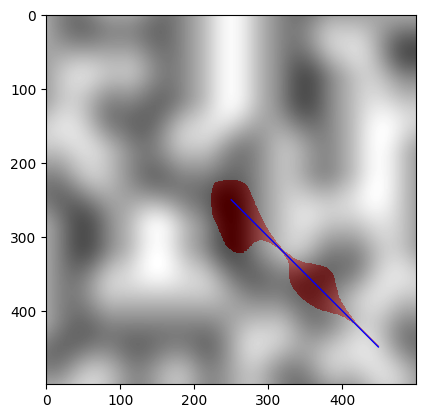

In [65]:
seed = 3

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

Time (s):  0.4826374053955078
Path cost: 197.24829713437708
Nodes explored:  3797


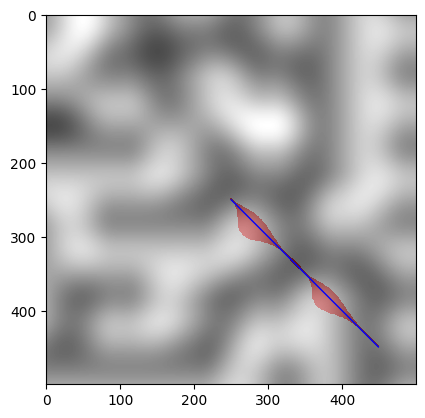

In [66]:
seed = 4

m = Map(w,l, seed=seed, cost_function = cost_function, filename=filename,
        start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)

## 4.2 MSH

Time (s):  14.772781610488892
Path cost: 515.2967010603603
Nodes explored:  144718


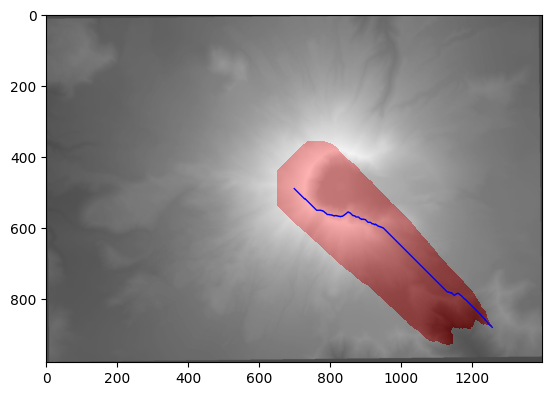

In [176]:
w = 500
l = 500
start = None
goal = None
seed = 0
# Change to AStarMSH() after implemented
AI = AStarMSH()
# Change to the filepath on your drive
filename = "/content/gdrive/My Drive/msh.npy"

m = Map(w,l, seed=seed, filename=filename, start=start, goal=goal)
t1 = time()
path = AI.createPath(m)
t2 = time()
print('Time (s): ', t2-t1)
m.createImage(path)